In [1]:
import os 

import numpy as np

from astropy.cosmology import WMAP5 as cosmo
from astropy.table import Table
from astropy import units as u 
from astropy.coordinates import SkyCoord

import kcorrect
import kcorrect.utils as ut

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
plt.rcParams['figure.figsize'] = [12, 12]

# Load Astrodeep Catalogs

In [3]:
filter_list = [
    'MAG_B435',
    'MAG_V606',
    'MAG_I814',
    'MAG_Y105',
    'MAG_J125',
    'MAG_JH140',
    'MAG_H160',
    #'MAG_IRAC1',
    #'MAG_IRAC2'
]

hst_correction_const_dict = {
    'MAG_B435': 0.102,
    'MAG_V606': -0.088,
    'MAG_I814': -0.426,
    'MAG_Y105': -0.647,
    'MAG_J125': -0.903,
    'MAG_JH140': -1.078,
    'MAG_H160': -1.254,
    'MAG_IRAC1': -2.787,
    'MAG_IRAC2': -3.260
}

In [4]:
# raw_astro_deep_cat = Table.read("https://stsci.box.com/shared/static/2dsckrbt7b4eocl2v2mot9ssso0stc11.cat", format="ascii")
raw_astro_deep_cat = Table.read("http://astrodeep.u-strasbg.fr/ff/data/catalogues/A2744CL.xml")

print(len(raw_astro_deep_cat))

3587


In [5]:
min_z = 0.1
max_z = 1

min_mag = 0
max_mag = 24

astro_deep_mask = np.ones((len(raw_astro_deep_cat))).astype(bool)

#astro_deep_mask = astro_deep_mask & np.invert(raw_astro_deep_cat['ZBEST'].mask.astype(bool))
astro_deep_mask = astro_deep_mask & (raw_astro_deep_cat['ZBEST'] > min_z).astype(bool).data  
astro_deep_mask = astro_deep_mask & (raw_astro_deep_cat['ZBEST'] < max_z).astype(bool).data 
astro_deep_mask = astro_deep_mask & (raw_astro_deep_cat['ZBEST'] != 0).astype(bool).data 

for f in filter_list:
    astro_deep_mask = astro_deep_mask & (raw_astro_deep_cat[f] > min_mag).astype(bool).data
    astro_deep_mask = astro_deep_mask & (raw_astro_deep_cat[f] < max_mag).astype(bool).data 


astro_deep_cat = raw_astro_deep_cat[astro_deep_mask]
print(len(astro_deep_cat))

74


In [6]:
cat = {}

mags = {}
mag_err = {}

maggies = {}
maggies_err = {}

z_best = np.array(astro_deep_cat['ZBEST'])

num_sources = None

for f in filter_list:
    cat[f] = astro_deep_cat[f]
    
    mags[f] = np.array(astro_deep_cat[f][:]) 
    mag_err[f] = np.array(astro_deep_cat[f.replace('MAG_', 'MAGERR_')][:]) 
    
    maggies[f] = ut.mag2maggies(mags[f])
    maggies_err[f] = ut.invariance(maggies[f], mag_err[f])
    
    if num_sources is None:
        num_sources = len(cat[f])
    else:
        assert num_sources == len(cat[f])

        

In [71]:
robel_cat = Table.read('hlsp_frontier_hst_wfc3-60mas_abell2744_f105w_v1.0_drz_catalog_fine_petrosian.csv')
robel_ra, robel_dec = np.array([ coord.split(',') for coord in robel_cat['sky_centroid']]).astype(float).transpose()

robel_coords = SkyCoord(
    ra=robel_ra*u.degree,
    dec=robel_dec*u.degree
)

astro_deep_coords = SkyCoord(
    ra=np.array(astro_deep_cat['RA'])*u.degree,
    dec=np.array(astro_deep_cat['DEC'])*u.degree
)


idx, sep2d, dist3d = astro_deep_coords.match_to_catalog_sky(robel_coords)

radii = robel_cat['r_half_light_arcsec'][idx] 
radii[np.where(sep2d.arcsec > 0.5)] = np.nan

print("Num sources with radii matchs: ", np.where(sep2d.arcsec < 0.1)[0].shape[0])
print("Fraction sources with radii matchs: ", 1 - np.where(sep2d.arcsec > 0.1)[0].shape[0] / len(astro_deep_cat))

Num sources with radii matchs:  55
Fraction sources with radii matchs:  0.7432432432432432


single bin width= 0.008125


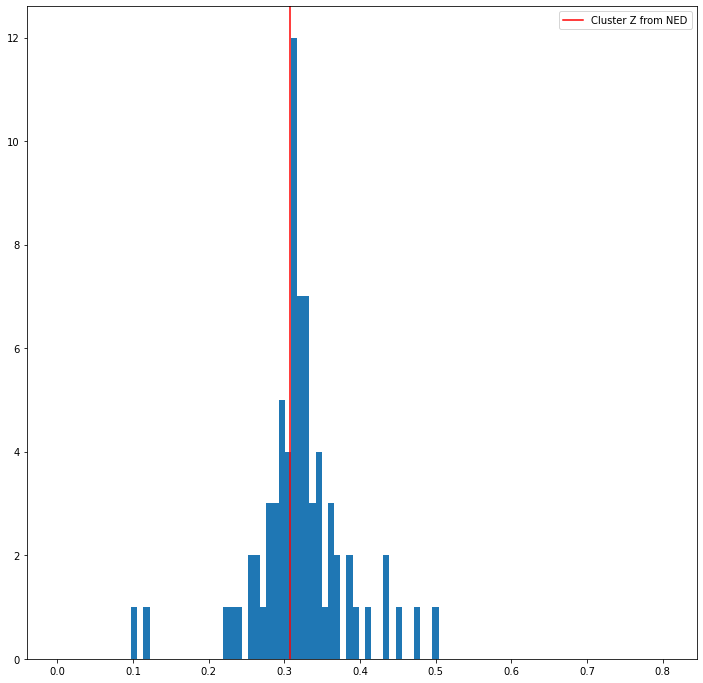

In [72]:
num_bins = 100
max_value = z_best[~np.isnan(z_best)].max()
bin_width = (max_value / num_bins)
print('single bin width=', bin_width)
plt.hist(z_best, bins=[i * bin_width for i in range(num_bins)]);
plt.axvline(0.308, c='r', label='Cluster Z from NED')
plt.legend()
plt.show()

In [73]:
cluster_mask = np.array([np.where(astro_deep_cat['ID'] == ID )[0][0] for ID in range(100001, 100016) if len(np.where(astro_deep_cat['ID'] == ID )[0])])
if len(cluster_mask):
    z_best[cluster_mask] = 0.308

#z_best[np.where(np.isnan(z_best))] = 0.308
#z_best[astro_deep_cat['ZBEST'].mask.astype(bool)] = 0.308

# Load Input Filters

In [74]:
def print_filter_file(path):
    with open(path) as f:
        for line in f:
            print(line.replace("\n", ""))

In [75]:
input_filter_file = os.path.abspath('hst_filters_2.dat')

In [76]:
print_filter_file(input_filter_file)

KCORRECT_DIR
data/filters/clash_acs_f435w.par
data/filters/clash_acs_f606w.par
data/filters/clash_acs_f814w.par
data/filters/clash_wfc3_f105w.par
data/filters/clash_wfc3_f125w.par
data/filters/clash_wfc3_f140w.par
data/filters/clash_wfc3_f160w.par


In [77]:
kcorrect.load_templates()
kcorrect.load_filters(input_filter_file)

# Fit Nonnegative Sums

In [78]:
kcorrect_constants = []

for i in range(0, num_sources):
    
    all_maggies = np.array([maggies[f][i] for f in filter_list], dtype=float)
    all_maggies_err = np.array([maggies_err[f][i] for f in filter_list], dtype=float)
    
    z = z_best[i]
    
    constants = kcorrect.fit_nonneg(z, all_maggies, all_maggies_err)
    
    kcorrect_constants.append(constants)
    

# Reconstruct Maggies

In [79]:
def multi_reconstruct_maggies(kcorrect_constants, filter_list, redshift=-1.0):
    re_maggies = {f: [] for f in filter_list}
    
    for constants in kcorrect_constants:
        _, *result = kcorrect.reconstruct_maggies(constants, redshift=redshift)

        for i, f in enumerate(filter_list):
            re_maggies[f].append(result[i])
            
    for i, f in enumerate(filter_list):
        re_maggies[f] = np.array(re_maggies[f])
        
    return re_maggies
    

In [80]:
def stack_filter_dict(dictionary):
    return np.stack(tuple(dictionary.values()), axis=-1)

In [81]:
re_maggies = multi_reconstruct_maggies(kcorrect_constants, filter_list)
re_maggies_z0 = multi_reconstruct_maggies(kcorrect_constants, filter_list, redshift=0)

# Compare Reconstructed Maggies Vs Input Maggies

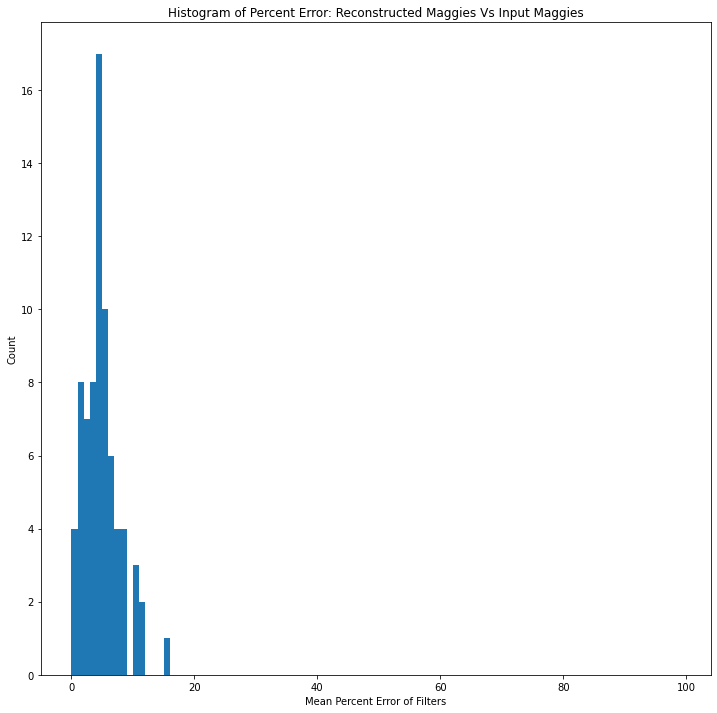

N=74


In [82]:
all_re_maggies = stack_filter_dict(re_maggies)
all_maggies = stack_filter_dict(maggies)

percent_err = 100 * abs(all_re_maggies - all_maggies) / all_maggies
percent_err = (percent_err).mean(axis=1)

bins = list(range(100))
plt.hist(percent_err, bins=bins)

#plt.xticks(bins, ["{:0.2e}".format(i) for i in bins], rotation='vertical')

plt.title("Histogram of Percent Error: Reconstructed Maggies Vs Input Maggies")
plt.xlabel("Mean Percent Error of Filters")
plt.ylabel("Count")
plt.show()

"""
bins = 0.1*np.array(range(100))
plt.hist(percent_err, bins=bins)

plt.title("Histogram of Percent Error: Reconstructed Maggies Vs Input Maggies")
plt.xlabel("Mean Percent Error of Filters")
plt.ylabel("Count")
plt.show()
"""
print("N={}".format(len(percent_err)))

# Load Johnson Filters

In [83]:
johnson_filter_list = ['u', 'b', 'v']

johnson_correction_const_dict = {
    'u': -0.79,
    'b': + 0.09,
    'v': -0.02
}

johnson_correction_const = np.array([johnson_correction_const_dict[key] for key in johnson_filter_list])

In [84]:
johnson_filter_file = os.path.abspath('johnson_ubv.dat')

In [85]:
print_filter_file(johnson_filter_file)

KCORRECT_DIR
data/filters/bessell_U.par
data/filters/bessell_B.par
data/filters/bessell_V.par


In [86]:
kcorrect.load_templates()
kcorrect.load_filters(johnson_filter_file)

# Compute Johnson Maggies 

In [87]:
johnson_maggies_z0 = multi_reconstruct_maggies(kcorrect_constants, johnson_filter_list, redshift=0)

# Compute Vega Mag 

In [88]:
m_vega_mags = {}
M_vega_mags = {}

# Johnson filters
for i, f in enumerate(johnson_filter_list):
    m_vega_mags[f] = -2.5 * np.log10(johnson_maggies_z0[f]) + johnson_correction_const_dict[f]
    M_vega_mags[f] = m_vega_mags[f] - cosmo.distmod(z_best).value

# Original filters
for i, f in enumerate(filter_list):
    m_vega_mags[f] = -2.5 * np.log10(re_maggies_z0[f]) + hst_correction_const_dict[f]
    M_vega_mags[f] = m_vega_mags[f] - cosmo.distmod(z_best).value


# Compute Surface Brightnesses

In [89]:
m_b = m_vega_mags['b']

In [90]:
r_half_light_arcsec = radii

In [91]:
surface_brightness = m_b + 5 * np.log10(r_half_light_arcsec) + 2.5 * np.log10(2 * np.pi) - 10 * np.log10(1+z_best)
surface_brightness[np.where(np.isnan(surface_brightness))] = np.nan

# Make Catalog

In [92]:
# Define Column Names 
col_names = [
    'id',
    'ra', 'dec',
    'zbest',
    'mstar',
    'surface_brightness',
    'r_half_light_arcsec',
    
] 

col_names += ["m_{}".format(f.replace('MAG_','')) for f in m_vega_mags.keys()] 
col_names += ["M_{}".format(f.replace('MAG_','')) for f in M_vega_mags.keys()]
col_names += ["kcorrect_constant_{}".format(i) for i in range(len(kcorrect_constants[0]))]

# Construct the rows of the catalog
final_catalog_rows = [
    astro_deep_cat['ID'],
    astro_deep_cat['RA'],
    astro_deep_cat['DEC'],
    z_best,
    astro_deep_cat['MSTAR'],
] 
final_catalog_rows += [surface_brightness]
final_catalog_rows += [r_half_light_arcsec]
final_catalog_rows += list(m_vega_mags.values()) 
final_catalog_rows += list(M_vega_mags.values()) 
final_catalog_rows += list(map(list, zip(*kcorrect_constants)))    

# Make the catalog
final_catalog = Table(data=final_catalog_rows, names=col_names)


# Mask out sources with missing values
# r80 is a good indicator that things failed so we use that column to mask
catalog_mask =  (
    np.invert(final_catalog['surface_brightness'].mask) & 
    np.invert(np.isnan(np.array(surface_brightness, dtype=float))).astype(bool) & 
    np.invert(np.isnan(radii)).astype(bool) &
    (final_catalog['m_I814'] < 23).astype(bool) # &
    #(final_catalog['surface_brightness'] < 25)
    #(final_catalog['zbest'] > 0.25).astype(bool)&
    #(final_catalog['zbest'] < 0.35).astype(bool)
)

print(len(final_catalog))
final_catalog = final_catalog[catalog_mask]
print(len(final_catalog))

final_catalog.sort(keys="r_half_light_arcsec", reverse=1)

74
64


In [93]:
final_catalog

id,ra,dec,zbest,mstar,surface_brightness,r_half_light_arcsec,m_u,m_b,m_v,m_B435,m_V606,m_I814,m_Y105,m_J125,m_JH140,m_H160,M_u,M_b,M_v,M_B435,M_V606,M_I814,M_Y105,M_J125,M_JH140,M_H160,kcorrect_constant_0,kcorrect_constant_1,kcorrect_constant_2,kcorrect_constant_3,kcorrect_constant_4,kcorrect_constant_5
,deg,deg,,1E9solMass,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32
1598,3.60005,-30.389715,0.3700000047683716,102.7,21.775564313301565,1.8023521363489796,19.832407,19.868122,19.23043,19.914995,18.998993,18.204697,17.598791,17.21239,16.96237,16.695955,-21.65992123606658,-21.624206132917166,-22.2618976307199,-21.5773330402658,-22.49333531382537,-23.287631578473807,-23.89353711131072,-24.27993733408904,-24.529958314924002,-24.796372957257987,0.37,5.689442e-07,9.972823e-10,2.3615586e-07,4.227856e-06,1.7004089e-09
1117,3.598973,-30.397516,0.28999999165534973,57.65,22.62449506218356,1.3600397558585051,21.40016,21.067184,20.19973,21.118612,19.96147,19.048227,18.422647,18.035889,17.786768,17.519108,-19.4748647266831,-19.807840114256344,-20.675294643064937,-19.75641227306982,-20.913554912229976,-21.826797252317867,-22.452377086302242,-22.83913589062353,-23.088256602903805,-23.355916743895015,0.29,1.646987e-07,8.491214e-39,1.3822333e-11,2.6315588e-06,1.27318796e-08
2075,3.584968,-30.383724,0.23909999430179596,2.76,22.621574390199648,1.0850888166346966,21.172812,21.379862,21.039955,21.412308,20.861685,20.34458,19.950632,19.63187,19.418653,19.195395,-19.22209650012139,-19.01504617663506,-19.354952869139943,-18.982600269042287,-19.533223209105763,-20.050328311644826,-20.444275912963185,-20.76303773852471,-20.97625452014092,-21.19951349230889,0.2391,7.009836e-08,1.5230414e-10,8.692762e-08,1.9900872e-08,3.6238188e-08
337,3.598509,-30.408403,0.4309999942779541,18.6,20.757593500167985,1.0163510818287447,19.992523,20.283321,19.96372,20.310663,19.810877,19.26659,18.89841,18.572983,18.35965,18.137487,-21.892872402926955,-21.602074215671095,-21.921675274631056,-21.574732373019728,-22.074518749972853,-22.618805477878126,-22.98698479916719,-23.312412808200392,-23.525745938083205,-23.747908184787306,0.431,2.4010694e-07,3.4718275e-10,1.02624305e-07,4.5267026e-08,1.7595255e-07
1809,3.574393,-30.383654,0.2750000059604645,0.0,21.26533218514645,0.9685335271811256,20.509169,20.394411,19.645048,20.43817,19.41585,18.516117,17.877562,17.464499,17.20406,16.928846,-20.23295946673879,-20.347717004580588,-21.09707995013723,-20.303958612246603,-21.326278405947775,-22.226010995669455,-22.864566522402853,-23.27762957171926,-23.538068490786642,-23.81328173236379,0.275,6.6613916e-07,1.6871337e-32,2.6558691e-11,3.1981579e-06,8.598787e-08
154,3.569589,-30.412163,0.2824000120162964,14.42,22.4777414185054,0.9386475555263638,21.786629,21.700014,21.069859,21.740301,20.862995,20.113167,19.599247,19.260357,19.035719,18.79253,-19.021869449835116,-19.108484058599764,-19.738639621954256,-19.0681970407775,-19.94550302527457,-20.695331363897616,-21.20925119421988,-21.548141269903475,-21.772779255132967,-22.015968113165194,0.2824,6.4051435e-09,1.28e-43,3.5895006e-08,7.5182396e-07,1.9934767e-08
1656,3.585312,-30.387545,0.3012000024318695,38.22,21.25556238744819,0.8997957923751735,20.784689,20.632833,20.042057,20.675238,19.818966,19.101284,18.559399,18.198185,17.961502,17.709112,-20.18552204173315,-20.33737751048315,-20.928153953964596,-20.294973335678463,-21.151245079452877,-21.868926964218502,-22.410812340195065,-22.772026024277096,-23.0087089161228,-23.261098823959713,0.3012,1.7434657e-07,1.4947861e-35,2.0620259e-07,1.3434196e-06,1.8557241e-08
1024,3.574901,-30.39838,0.3174000084400177,100.2,21.05609055389677,0.825080863238269,21.01476,20.675335,19.854137,20.726685,19.607922,18.711012,18.068441,17.666952,17.410725,17.138012,-20.0875516151304,

# Cluster Catalog

In [94]:
cluster_mask = np.array([np.where(final_catalog['id'] == ID )[0][0] for ID in range(100001, 100016) if len(np.where(final_catalog['id'] == ID )[0])])

cluster_catalog = final_catalog[cluster_mask]

cluster_M_B = np.array(cluster_catalog['M_b'])
cluster_M_V = np.array(cluster_catalog['M_v'])
cluster_B_minus_V = cluster_M_B - cluster_M_V
cluster_sb = cluster_catalog['surface_brightness']

# LCBG Catalog

In [101]:
M_B = np.array(final_catalog['M_b'])
M_V = np.array(final_catalog['M_v'])
B_minus_V = M_B-M_V
sb = final_catalog['surface_brightness']

r_half_light_arcsec_list = final_catalog['r_half_light_arcsec']
lcbg_mask = np.where(
    (B_minus_V < 0.5).astype(int) & 
    (sb < 21).astype(int) & 
    (M_B < -18.5).astype(int) & 
    
    #(final_catalog['zbest'] < 0.5).astype(int)&
    #(final_catalog['zbest'] > 0.1).astype(int)&
    
    #(r_half_light_arcsec_list < 0.5).astype(int) & # Guzman et al. (1997) and Phillips et al. (1997)
    (0.2 < r_half_light_arcsec_list).astype(int)   # Remove star like objects
)

lcbg_catalog = final_catalog[lcbg_mask]
len(lcbg_catalog)

2

# Save Catalog

In [102]:
output_catalog_filename = "astrodeep_abell370_catalog.csv"
output_lcbg_catalog_filename = "astrodeep_abell370_lcbg_catalog.csv"

In [ ]:
astrodeep_abell370_catalog.csv

In [103]:
final_catalog.write(output_catalog_filename, format="ascii.csv", overwrite=True)
lcbg_catalog.write(output_lcbg_catalog_filename, format="ascii.csv", overwrite=True)

# Plots

### Plot B-V vs M<sub>b</sub> 

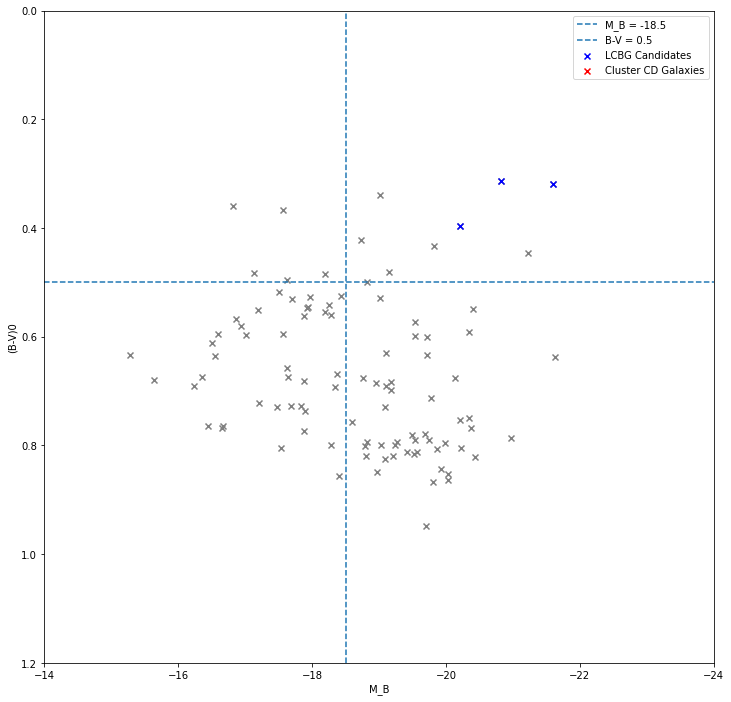

In [98]:
plt.scatter(M_B, B_minus_V, color="gray", marker='x')

plt.axvline(-18.5, label='M_B = -18.5', linestyle='--')
plt.axhline(0.5, label='B-V = 0.5', linestyle='--')

plt.scatter(M_B[lcbg_mask], B_minus_V[lcbg_mask], label='LCBG Candidates', c='b', marker='x')
plt.scatter(cluster_M_B, cluster_B_minus_V, label='Cluster CD Galaxies', c='r', marker='x')

plt.xlabel('M_B')
plt.ylabel('(B-V)0')

plt.xlim(-14, -24)
plt.ylim(1.2, -0)

plt.legend()


### Plot Surface Brightness Vs M_B

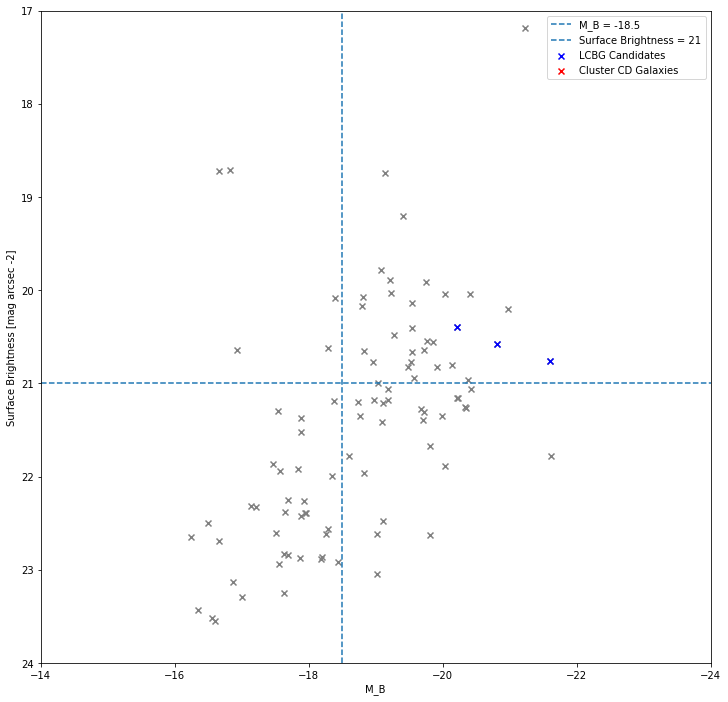

In [99]:
plt.scatter(M_B, sb, color="gray", marker='x')

plt.axvline(-18.5, label='M_B = -18.5', linestyle='--')
plt.axhline(21, label='Surface Brightness = 21', linestyle='--')

plt.scatter(M_B[lcbg_mask], sb[lcbg_mask], label='LCBG Candidates', c='b', marker='x')
plt.scatter(cluster_M_B, cluster_sb, label='Cluster CD Galaxies', c='r', marker='x')

plt.xlabel('M_B')
plt.ylabel('Surface Brightness [mag arcsec -2]')

plt.xlim(-14, -24)
plt.ylim(24, 17)

plt.legend()

### Plot Surface Brightness Vs B-V

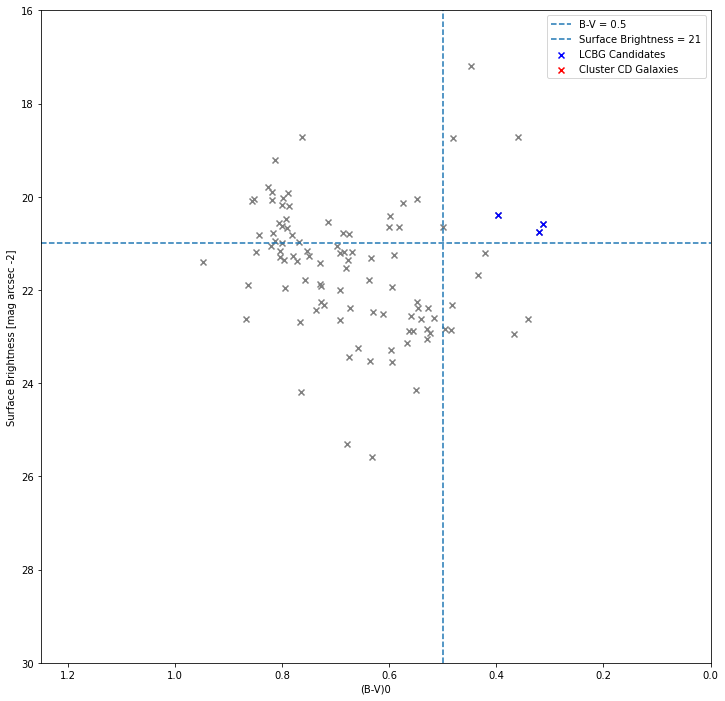

In [100]:
plt.scatter(B_minus_V, sb, color="gray", marker='x')

plt.axvline(0.5, label='B-V = 0.5', linestyle='--')
plt.axhline(21, label='Surface Brightness = 21', linestyle='--')

plt.scatter(B_minus_V[lcbg_mask], sb[lcbg_mask], label='LCBG Candidates', c='b', marker='x')
plt.scatter(cluster_B_minus_V, cluster_sb, label='Cluster CD Galaxies', c='r', marker='x')

plt.xlabel('(B-V)0')
plt.ylabel('Surface Brightness [mag arcsec -2]')

plt.xlim(1.25, 0.)
plt.ylim(30, 16)

plt.legend()

No handles with labels found to put in legend.


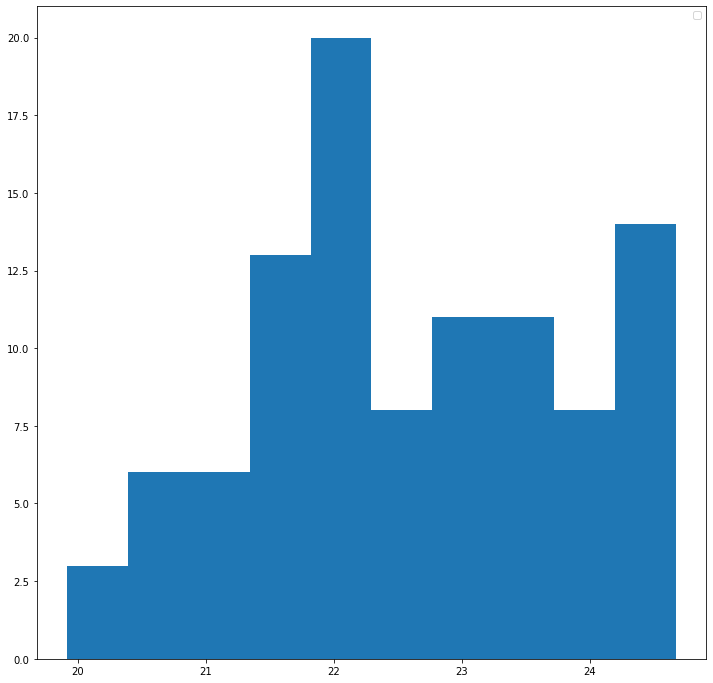

In [56]:

plt.hist(final_catalog['m_B435']);
plt.legend()
plt.show()

single bin width= 0.00996999979019165


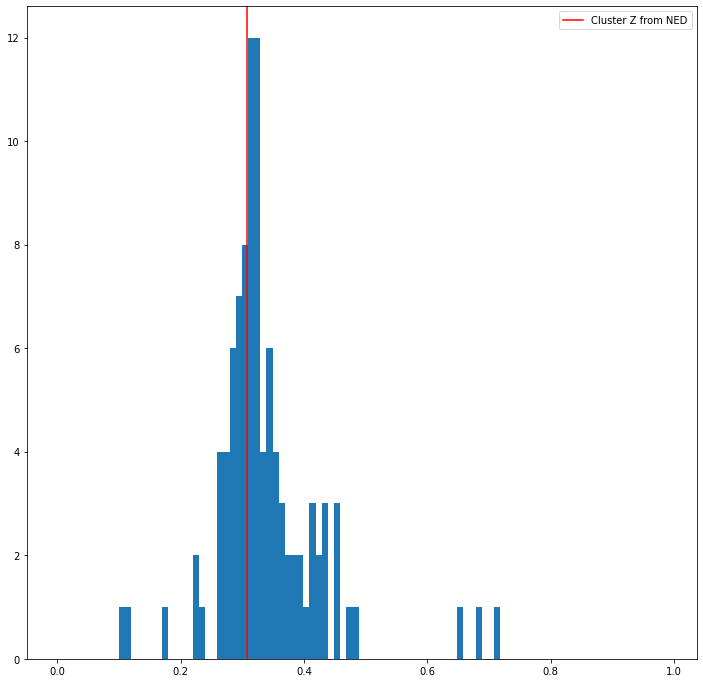

In [57]:
num_bins = 100
max_value = final_catalog['zbest'].max()
bin_width = (max_value / num_bins)
print('single bin width=', bin_width)
plt.hist(final_catalog['zbest'], bins=[i * bin_width for i in range(num_bins)]);
plt.axvline(0.308, c='r', label='Cluster Z from NED')
plt.legend()
plt.show()

# Save plots

In [58]:
Table([M_B, B_minus_V, sb], names=['M_B', 'B_minus_V', 'sb']).write('robel_B_minus_V_vs_sb.dat', format='ascii', overwrite=True)

## Plot (MAG_I814 - MAG_Y105) Vs. MAG_I814

Text(0, 0.5, 'm_I814')

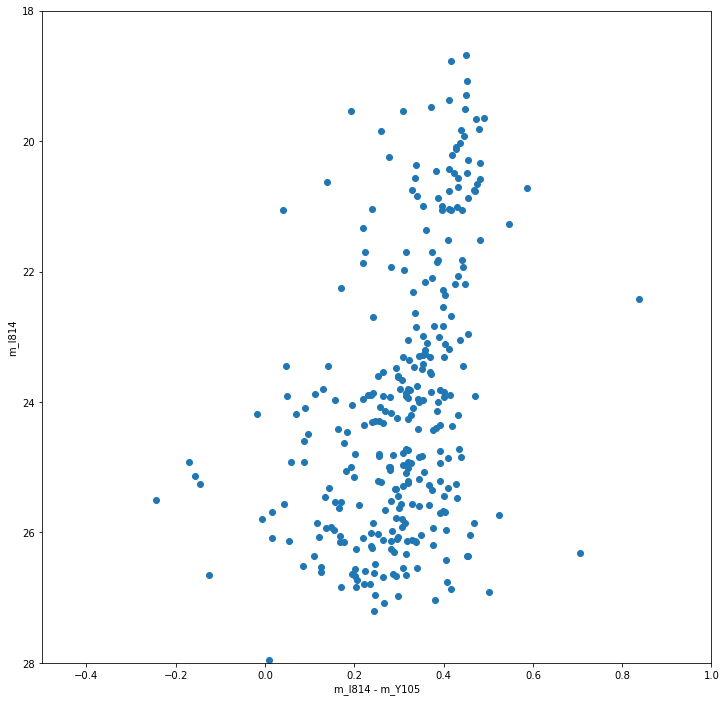

In [38]:
plt.scatter(mags['MAG_I814'][catalog_mask]-mags['MAG_Y105'][catalog_mask], 
            mags['MAG_I814'][catalog_mask])
plt.ylim(28, 18)
plt.xlim(-0.5, 1);
plt.xlabel("m_I814 - m_Y105")
plt.ylabel("m_I814")

`https://arxiv.org/pdf/1706.02521.pdf`

# Other

In [39]:
plt.scatter(j['MAG_I814']-mags['MAG_Y105'], mags[ 'MAG_I814'])
plt.ylim(28, 18)
plt.xlim(-0.5, 1);
plt.xlabel("m_I814 - m_Y105")
plt.ylabel("m_I814")

NameError: name 'j' is not defined

In [ ]:
plt.scatter(M_B, sb, color="gray", marker='x')

plt.axvline(-18.5, label='M_B = -18.5', linestyle='--')
plt.axhline(21, label='Surface Brightness = 21', linestyle='--')

plt.scatter(M_B[lcbg_mask], sb[lcbg_mask], label='LCBG Candidates', c='b', marker='x')
plt.scatter(cluster_M_B, cluster_sb, label='Cluster CD Galaxies', c='r', marker='x')

plt.xlabel('M_B')
plt.ylabel('Surface Brightness [mag arcsec -2]')

plt.xlim(-14, -24)
#plt.ylim(30, 16)

plt.legend()

In [ ]:
plt.scatter(M_B, sb, color="gray", marker='x')

plt.axvline(-18.5, label='M_B = -18.5', linestyle='--')
plt.axhline(21, label='Surface Brightness = 21', linestyle='--')

plt.scatter(M_B[lcbg_mask], sb[lcbg_mask], label='LCBG Candidates', c='b', marker='x')
#plt.scatter(cluster_M_B, cluster_sb, label='Cluster CD Galaxies', c='r', marker='x')

plt.xlabel('M_B')
plt.ylabel('Surface Brightness [mag arcsec -2]')

plt.xlim(-14, -30)
plt.ylim(11, 30)
##plt.ylim(30, 16)

plt.legend()

In [ ]:
[np.array(r_half_light_arcsec)[np.where(~np.isnan(r_half_light_arcsec))].min(),
np.array(r_half_light_arcsec)[np.where(~np.isnan(r_half_light_arcsec))].max(),
np.array(r_half_light_arcsec)[np.where(~np.isnan(r_half_light_arcsec))].mean()]

In [ ]:
"""
input_catalog_formatter = "hlsp_frontier_hst_wfc3-60mas_abell2744_{}_v1.0_drz_catalog_petrosian.csv"
robel_cat = Table.read(input_catalog_formatter.format('f105w'))

robel_ra, robel_dec = np.array([ coord.split(',') for coord in robel_cat['sky_centroid']]).astype(float).transpose()

radii = []
for row in astro_deep_cat:
    ra, dec = row['RA'], row['DEC'] 
    
    coord_delta = ((robel_ra - ra)**2 + (robel_dec - dec)**2)
    if coord_delta.min() > 1e-06:
        radii.append(np.nan)
        continue
        print(coord_delta.min())
    idx = coord_delta.argmin()
    
    radii.append(robel_cat[idx]['r_half_light_arcsec'])

radii = np.array(radii)
""";

In [ ]:
"""
robel_cat = Table.read('hlsp_frontier_hst_wfc3-60mas_abell2744_f105w_v1.0_drz_catalog_fine_petrosian.csv')
robel_ra, robel_dec = np.array([ coord.split(',') for coord in robel_cat['sky_centroid']]).astype(float).transpose()

radii = np.zeros_like(z_best)
radii[:] = np.nan

for col, [ra, dec] in enumerate(zip(robel_ra, robel_dec)):
    
    coord_delta = ((astro_deep_cat['RA'] - ra)**2 + (astro_deep_cat['DEC'] - dec)**2)
    if coord_delta.min() > 1e-05:
        print(coord_delta.min())
        continue
    idx = coord_delta.argmin()
    
    if not isinstance(robel_cat[col]['r_half_light_arcsec'], float):
        #radii[idx] = robel_cat[col]['semimajor_axis_sigma']
        radii[idx] = np.nan
    else:
        radii[idx] = robel_cat[col]['r_half_light_arcsec']
        
    if astro_deep_cat['ID'][idx]  == 100013:
        print(radii[idx], robel_cat[col]['id'])

radii = np.array(radii)
#radii[np.where(np.isnan(radii))] = 0.308
print("Num sources with radii matchs: ", np.where(sep2d.arcsec > 0.1)[0].shape[0])

print("Fraction sources with radii matchs: ", 1 - np.where(sep2d.arcsec > 0.1)[0].shape[0] / len(astro_deep_cat))
""";